In [37]:
!pip install dash

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import plotly.express as px
from dash import Dash, dcc, html
from dash.dependencies import Input, Output

In [38]:
df = pd.read_csv("C:/Users/91934/Downloads/Supermart Grocery Sales - Retail Analytics Dataset (1).csv")


In [39]:
# Convert Order Date to datetime
df["Order Date"] = pd.to_datetime(df["Order Date"], format="%d-%m-%Y", errors="coerce")


In [40]:
# Derived fields
df["COGS"] = df["Sales"] - df["Profit"]  # Assuming Profit = Sales - COGS
df["YearMonth"] = df["Order Date"].dt.to_period("M").astype(str)

In [41]:
# --- KPIs ---
total_revenue = float(df["Sales"].sum())
total_cogs = float(df["COGS"].sum())
total_income = float(df["Profit"].sum())

In [42]:
# --- Aggregations for charts ---
# Region share (donut)
region_share = df.groupby("Region")["Sales"].sum().sort_values(ascending=False)


In [43]:
# City share (Top 5 cities)
city_share = df.groupby("City")["Sales"].sum().sort_values(ascending=False).head(5)

In [44]:
# Category share
category_share = df.groupby("Category")["Sales"].sum().sort_values(ascending=False)


In [45]:
# Sub-Category sales (Top 6)
subcat_share = df.groupby("Sub Category")["Sales"].sum().sort_values(ascending=False).head(6)

In [46]:
# Profit Margin by Category
df["ProfitMargin"] = np.where(df["Sales"] != 0, df["Profit"] / df["Sales"], 0.0)
margin_by_cat = df.groupby("Category")["ProfitMargin"].mean().sort_values(ascending=False)

In [47]:
# Top 5 States by Sales
state_sales = df.groupby("State")["Sales"].sum().sort_values(ascending=False).head(5)

In [48]:
# Order quantity by Sub-Category (Top 6)
qty_by_subcat = df["Sub Category"].value_counts().head(6)

In [49]:
# Discount bands
bins = [0, 0.05, 0.1, 0.2, 0.3, df["Discount"].max() + 1e-9]
labels = ["0-5%", "5-10%", "10-20%", "20-30%", "30%+"]
df["DiscountBand"] = pd.cut(df["Discount"], bins=bins, labels=labels, include_lowest=True, right=False)
discount_counts = df["DiscountBand"].value_counts().reindex(labels)

In [50]:
# --- Create Dashboard ---
plt.figure(figsize=(18, 10))
gs = GridSpec(3, 4, height_ratios=[0.9, 2.3, 2.5], width_ratios=[1, 1, 1, 1])

<Figure size 1800x1000 with 0 Axes>

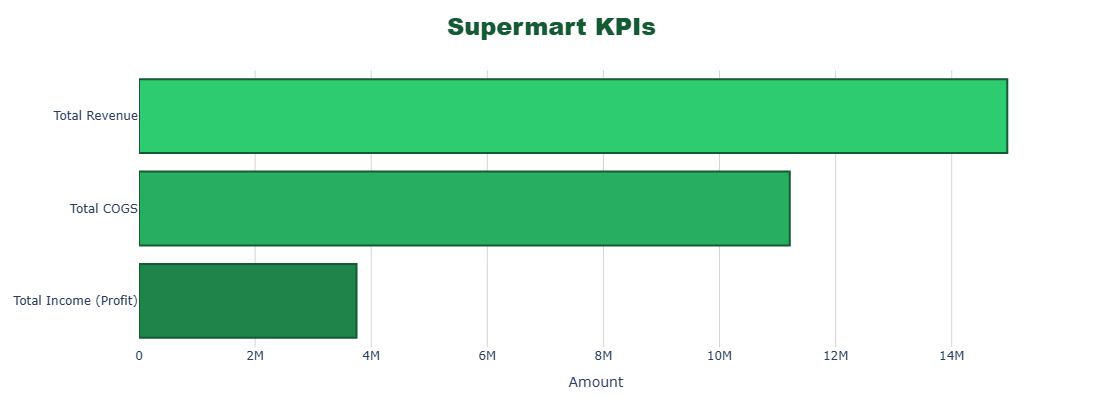

In [74]:
import plotly.graph_objects as go

# Data for KPIs
kpi_names = ["Total Revenue", "Total COGS", "Total Income (Profit)"]
kpi_values = [total_revenue, total_cogs, total_income]

# Create figure
fig = go.Figure()

# Add horizontal bar chart
fig.add_trace(go.Bar(
    x=kpi_values,
    y=kpi_names,
    orientation='h',
    marker=dict(
        color=['#2ECC71', '#27AE60', '#1E8449'],  # Shades of green
        line=dict(color='#145A32', width=2)       # Dark green border
    ),
    hovertemplate='%{y}: %{x:,.0f}<extra></extra>',  # Show value on hover only
    text=None
))

# Layout styling
fig.update_layout(
    title=dict(
        text="Supermart KPIs",
        x=0.5,
        xanchor='center',
        font=dict(size=24, color='#145A32', family='Arial Black')
    ),
    xaxis=dict(
        title="Amount",
        showgrid=True,
        gridcolor='lightgray',
        zeroline=False
    ),
    yaxis=dict(
        showgrid=False,
        autorange='reversed'  # Top KPI first
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    margin=dict(l=100, r=50, t=70, b=50),
    height=400
)

fig.show()


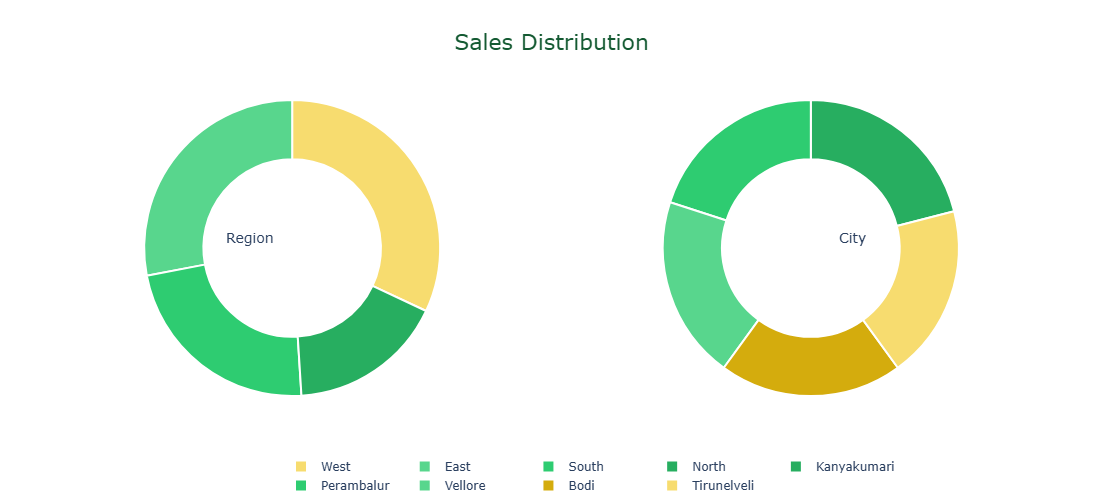

In [70]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Data
region_share = {"North": 17, "South": 23, "East": 28, "West": 32}
city_share = {"Kanyakumari": 21, "Perambalur": 20, "Vellore": 20, "Tirunelveli": 19, "Bodi": 20}

# Colors (Green-Yellow Theme)
colors_region = ['#27AE60', '#2ECC71', '#58D68D', '#F7DC6F']
colors_city = ['#27AE60', '#2ECC71', '#58D68D', '#F7DC6F', '#D4AC0D']

# Create subplots (two donut charts)
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type':'domain'}, {'type':'domain'}]],
    subplot_titles=["Region Sales Share", "Top Cities Sales Share"]
)

# Region Donut
fig.add_trace(go.Pie(
    labels=list(region_share.keys()), 
    values=list(region_share.values()),
    hole=0.6,
    marker=dict(colors=colors_region, line=dict(color='white', width=2)),
    hoverinfo='label+percent',
    textinfo='none'
), 1, 1)

# City Donut
fig.add_trace(go.Pie(
    labels=list(city_share.keys()), 
    values=list(city_share.values()),
    hole=0.6,
    marker=dict(colors=colors_city, line=dict(color='white', width=2)),
    hoverinfo='label+percent',
    textinfo='none'
), 1, 2)

# Layout styling
fig.update_layout(
    title=dict(text="Sales Distribution", x=0.5, xanchor='center', font=dict(size=22, color='#145A32')),
    annotations=[
        dict(text='Region', x=0.18, y=0.5, font_size=14, showarrow=False),
        dict(text='City', x=0.82, y=0.5, font_size=14, showarrow=False)
    ],
    showlegend=True,
    legend=dict(orientation="h", y=-0.15, x=0.3),
    paper_bgcolor="white",
    plot_bgcolor="white",
    height=500
)

fig.show()


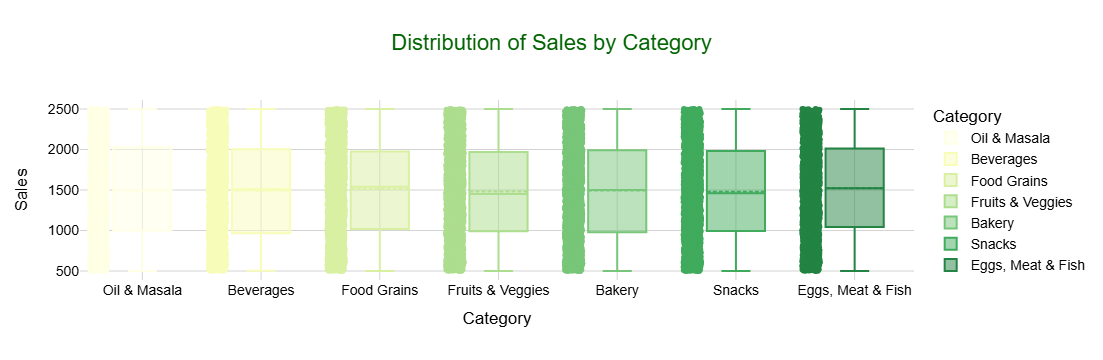

In [77]:
import plotly.express as px

# Create a box plot of Sales distribution by Category with hover details
fig = px.box(
    df,
    x='Category',
    y='Sales',
    color='Category',
    color_discrete_sequence=px.colors.sequential.YlGn,
    title="Distribution of Sales by Category",
    points="all"  # Show individual data points
)

# Customize hover template to include Count, Median, and Mean
fig.update_traces(
    hovertemplate=(
        "<b>Category:</b> %{x}<br>"
        "<b>Sales:</b> %{y}<br>"
        "<extra></extra>"
    ),
    boxmean=True  # Show mean line inside box
)

# Update layout for a white dashboard style
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(size=14, family="Arial", color="black"),
    xaxis=dict(showgrid=True, gridcolor='lightgrey', title="Category"),
    yaxis=dict(showgrid=True, gridcolor='lightgrey', title="Sales"),
    title=dict(x=0.5, xanchor='center', font=dict(size=22, color='darkgreen'))
)

fig.show()


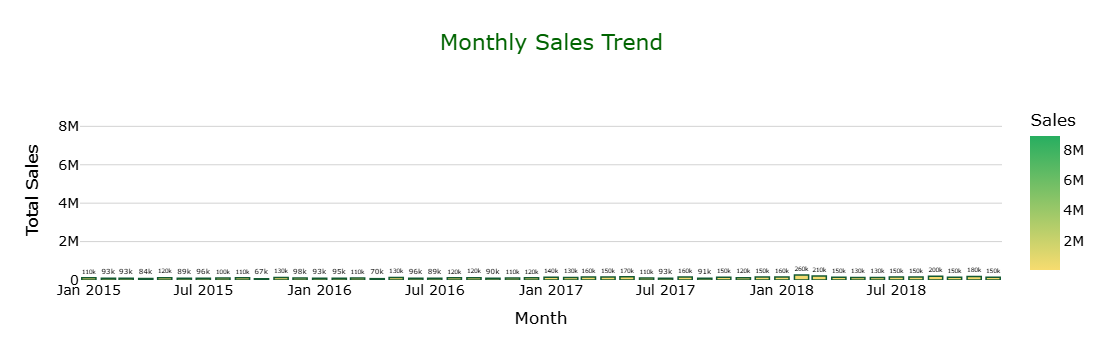

In [82]:
import pandas as pd
import plotly.express as px

# Ensure 'Order Date' is datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Extract Year-Month and group by month
df['Month'] = df['Order Date'].dt.to_period('M').astype(str)
monthly_sales = df.groupby('Month')['Sales'].sum().reset_index()

# Create bar chart
fig = px.bar(
    monthly_sales,
    x='Month',
    y='Sales',
    title="Monthly Sales Trend",
    text_auto='.2s',  # Shows values on top of bars in compact format
    color='Sales',
    color_continuous_scale=['#F7DC6F', '#27AE60']  # Yellow to Green gradient
)

# Customize layout
fig.update_traces(
    hovertemplate="<b>Month:</b> %{x}<br><b>Total Sales:</b> %{y:,.2f}<extra></extra>",
    marker_line=dict(color='#145A32', width=1.5)
)

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(
        title="Month",
        showgrid=False
    ),
    yaxis=dict(
        title="Total Sales",
        showgrid=True,
        gridcolor='lightgray'
    ),
    font=dict(size=14, color='black'),
    title=dict(x=0.5, font=dict(size=22, color='darkgreen'))
)

fig.show()


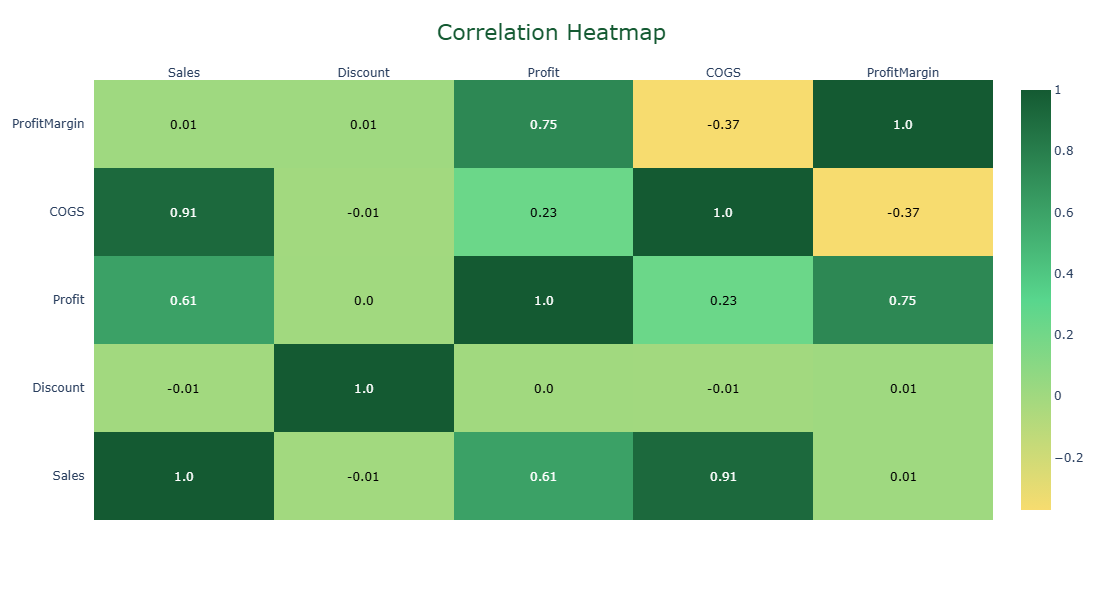

In [90]:
import pandas as pd
import plotly.figure_factory as ff

# Select numeric columns for correlation
numeric_df = df.select_dtypes(include='number')

# Compute correlation matrix
corr = numeric_df.corr()

# Create heatmap with correct colorscale format
fig = ff.create_annotated_heatmap(
    z=corr.values,
    x=list(corr.columns),
    y=list(corr.index),
    annotation_text=corr.round(2).values,
    colorscale=[[0.0, '#F7DC6F'], [0.5, '#58D68D'], [1.0, '#145A32']],  # ✅ Fixed
    showscale=True
)

# Layout Styling
fig.update_layout(
    title=dict(
        text="Correlation Heatmap",
        x=0.5,
        xanchor='center',
        font=dict(size=22, color='#145A32')
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    height=600,
    margin=dict(l=80, r=80, t=80, b=80)
)

fig.show()


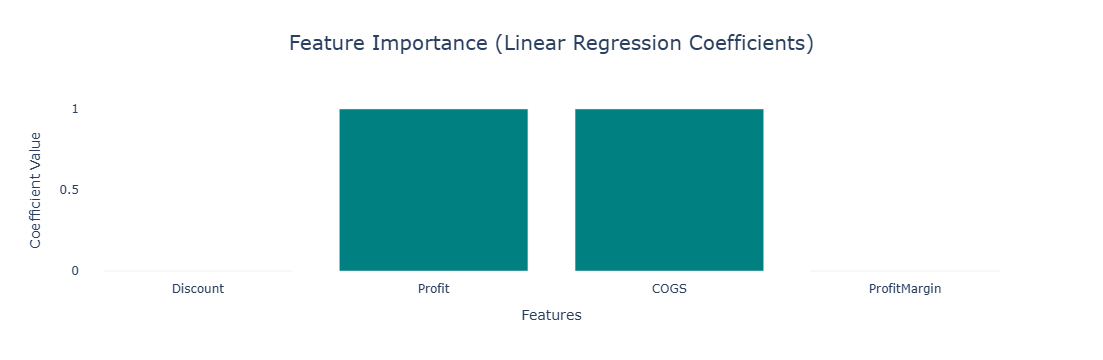

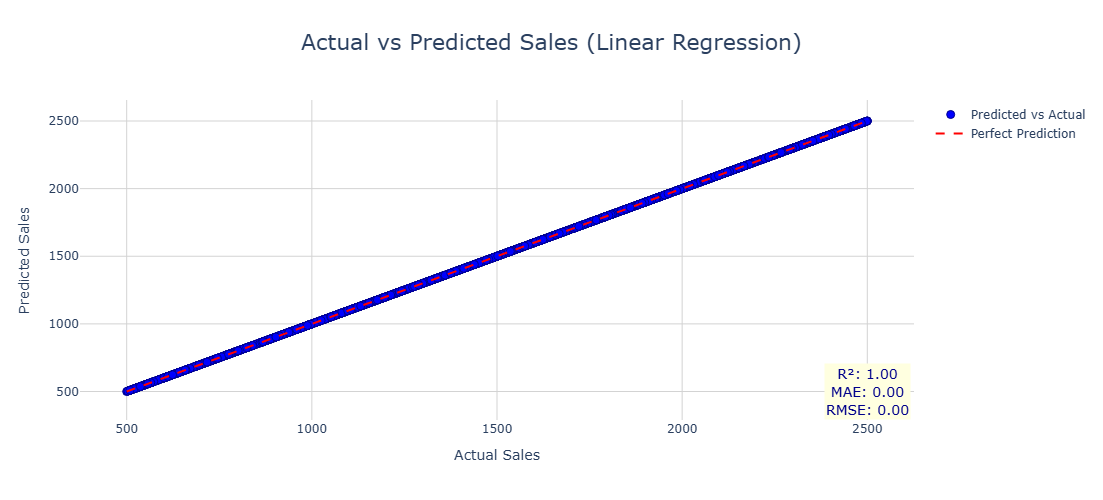

In [102]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import plotly.graph_objects as go


# Select valid features and target
X = df[['Discount', 'Profit', 'COGS', 'ProfitMargin']]
y = df['Sales']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# ------------------------------------------
# 1. BAR CHART – Feature Coefficients
# ------------------------------------------
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})

fig1 = go.Figure(go.Bar(
    x=coefficients['Feature'],
    y=coefficients['Coefficient'],
    marker_color='teal'
))
fig1.update_layout(
    title=dict(text="Feature Importance (Linear Regression Coefficients)", x=0.5, font=dict(size=20)),
    xaxis_title="Features",
    yaxis_title="Coefficient Value",
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# ------------------------------------------
# 2. SCATTER PLOT – Actual vs Predicted Sales
# ------------------------------------------
fig2 = go.Figure()

# Scatter points
fig2.add_trace(go.Scatter(
    x=y_test,
    y=y_pred,
    mode='markers',
    marker=dict(color='blue', size=8, line=dict(color='darkblue', width=1)),
    name='Predicted vs Actual'
))

# Perfect prediction line
fig2.add_trace(go.Scatter(
    x=[min(y_test), max(y_test)],
    y=[min(y_test), max(y_test)],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Perfect Prediction'
))

# Add metrics annotation
fig2.add_annotation(
    x=max(y_test),
    y=min(y_test),
    text=f"R²: {r2:.2f}<br>MAE: {mae:.2f}<br>RMSE: {rmse:.2f}",
    showarrow=False,
    font=dict(size=14, color="darkblue"),
    bgcolor='lightyellow'
)

fig2.update_layout(
    title=dict(text="Actual vs Predicted Sales (Linear Regression)", x=0.5, font=dict(size=22)),
    xaxis=dict(title="Actual Sales", gridcolor='lightgray'),
    yaxis=dict(title="Predicted Sales", gridcolor='lightgray'),
    plot_bgcolor='white',
    paper_bgcolor='white',
    height=500
)

# Show both charts
fig1.show()
fig2.show()
